In [58]:
import urllib.request, time, re, random, hashlib, nltk, functools, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from bs4 import BeautifulSoup 
from nltk.corpus import stopwords
from nltk import word_tokenize
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.util import *
from nltk.corpus import wordnet as wn
matplotlib.rc('figure', figsize=[10,6])
%matplotlib notebook

In [4]:
# Compassionate Caching inspired by 
# http://lethain.com/an-introduction-to-compassionate-screenscraping/

last_fetched_at = None

def fetch(url):
    """Load the url compassionately."""
    
    global last_fetched_at
    
    url_hash = hashlib.sha1(url.encode()).hexdigest()
    filename = 'cache-file-{}'.format(url_hash)
#     print(url_hash)
    try:
        with open(filename, 'r') as f:
            result = f.read()
            if len(result) > 0:
                print("Retrieving from cache:", url)
                return result
    except:
        pass
    
    print("Loading:", url)
    wait_interval = random.randint(3000,10000)
    if last_fetched_at is not None:
        now = time.time()
        elapsed = now - last_fetched_at
        if elapsed < wait_interval:
            time.sleep((wait_interval - elapsed)/1000)
        
    user_agent = 'Mozilla/5.0 (Windows NT 6.1; Win64; x64)'
    headers = { 'User-Agent' : user_agent }
    req = urllib.request.Request(url, headers = headers)
    last_fetched_at = time.time()
    with urllib.request.urlopen(req) as response:
        result = str(response.read())
        with open(filename, 'w') as f:
            f.write(result)
        return result

In [5]:
opinion_set = {'http://www.usatoday.com/story/opinion/2013/09/16/syria-irs-lerner-column/2816277/',
 'http://www.usatoday.com/story/opinion/2013/09/25/grocery-store-detroit-irs-column/2868797/',
 'http://www.usatoday.com/story/opinion/2014/05/12/president-obama-irs-scandal-watergate-column/8968317/',
 'http://www.usatoday.com/story/opinion/2014/08/28/russia-ukraine-nato-vladimir-putin-president-obama-editorials-debates/14766425/',
 'http://www.usatoday.com/story/opinion/2015/05/25/caption-contest-youtoon/1568271/',
 'http://www.usatoday.com/story/opinion/2015/07/23/highway-funding-oil-gasoline-tax-fix-congress-editorials-debates/30579385/',
 'http://www.usatoday.com/story/opinion/2015/12/21/cdc-opioids-heroin-overdoses-doctors-editorials-debates/77708774/',
 'http://www.usatoday.com/story/opinion/2016/02/01/mia-love-single-subject-rule-constitutional-amendment--reynolds-column/79605158/',
 'http://www.usatoday.com/story/opinion/2016/02/01/super-bowl-football-brain-damage-immoral-watch-column/79654086/',
 'http://www.usatoday.com/story/opinion/2016/02/04/obama--wrong-solitary-confinement-column/79649416/',
 'http://www.usatoday.com/story/opinion/2016/02/04/trump-sanders-mccain-new-hampshire-mavericks-column/79832920/',
 'http://www.usatoday.com/story/opinion/2016/02/07/journalists-jail-murder-censorship-turkey-editorials-debates/79844586/',
 'http://www.usatoday.com/story/opinion/2016/02/07/new-hampshire-primary-100-years-old-rebel-role-dante-scala-column/79967400/',
 'http://www.usatoday.com/story/opinion/2016/02/07/police-use-of-lethal-force-tellusatoday-your-say/79978876/',
 'http://www.usatoday.com/story/opinion/2016/02/07/turkish-ambassador-journalists-turkey-editorials-debates/79845450/',
 'http://www.usatoday.com/story/opinion/2016/02/07/voter-anger-elections-super-bowl-second-look/79967622/',
 'http://www.usatoday.com/story/opinion/2016/02/08/bill-de-blasio-chirlane-mccray-opioid-crisis-treatment-naloxone-overdoses-column/79972594/',
 'http://www.usatoday.com/story/opinion/2016/02/08/cal-thomas-elections-2016-god-religion-politics-evangelical-voters-column/79943324/',
 'http://www.usatoday.com/story/opinion/2016/02/08/federal-deficit-our-view-editorials-debates/80024164/',
 'http://www.usatoday.com/story/opinion/2016/02/08/federal-deficits-economy-governemtn-spending-editorials-debates/80032380/',
 'http://www.usatoday.com/story/opinion/2016/02/08/irs-tea-party-targeting-lois-lerner-corruption--obama-glenn-reynolds-column/79967098/',
 'http://www.usatoday.com/story/opinion/2016/02/08/martin-shkreli-drug-prices-your-say/80026236/',
 'http://www.usatoday.com/story/opinion/2016/02/08/primary-voting-presidential-election-tellusatoday-your-say/80026468/',
 'http://www.usatoday.com/story/opinion/2016/02/09/bernie-sanders-hillary-clinton-new-hampshire-column/80094342/',
 'http://www.usatoday.com/story/opinion/2016/02/09/beyonce-ads-super-bowl-colbert-corden-meyers-conan-jessica-williams/80052554/',
 'http://www.usatoday.com/story/opinion/2016/02/09/military-medical-battlefield-training-live-tissue-training-animal-rights-column/80018116/',
 'http://www.usatoday.com/story/opinion/2016/02/09/new-hampshire-primary-donald-trump-bernie-sanders-editorials-debates/80091284/',
 'http://www.usatoday.com/story/opinion/2016/02/09/obama-administration-least-transparent-epa-state-doj-clinton-benghazi-column/80050428/',
 'http://www.usatoday.com/story/opinion/2016/02/09/our-votes-matter-voter-id-citizens-united-voting-rights-act-democracy-awakens-column/80068028/',
 'http://www.usatoday.com/story/opinion/2016/02/09/solitary-confinement-federal-prisons-tellusatoday-your-say/80086320/',
 'http://www.usatoday.com/story/opinion/2016/02/09/super-bowl-50-your-say/80086738/',
 'http://www.usatoday.com/story/opinion/2016/02/09/trump-sanders-wins-new-hampshire-economic-anxiety-column/80088548/',
 'http://www.usatoday.com/story/opinion/2016/02/10/anthem-cruise-ship-storm-your-say/80202290/',
 'http://www.usatoday.com/story/opinion/2016/02/10/colbert-noah-fallon-kimmel-corden-sanders-trump-punchlines-new-hampshire/80179418/',
 'http://www.usatoday.com/story/opinion/2016/02/10/exonerations-dna-convicted-forensic-criminal-justice-column/80056392/',
 'http://www.usatoday.com/story/opinion/2016/02/10/hillary-clinton-women-voters-millennials-new-hampshire-column/80190950/',
 'http://www.usatoday.com/story/opinion/2016/02/10/hillary-clintons-woman-problem-column/80175130/',
 'http://www.usatoday.com/story/opinion/2016/02/10/marco-rubio-hip-hop-ben-carson-trump-bush-young-minority-voters-column/76387044/',
 'http://www.usatoday.com/story/opinion/2016/02/10/new-hampshire-primary-donald-trump-bernie-sanders-tellusatoday-your-say/80202062/',
 'http://www.usatoday.com/story/opinion/2016/02/10/oil-prices-gasoline-revenue-american-petroleum-institute-editorials-debates/80193760/',
 'http://www.usatoday.com/story/opinion/2016/02/10/oil-tax-10-barrel-infrastructure-president-obama-climate-change-editorials-debates/80056688/',
 'http://www.usatoday.com/story/opinion/2016/02/10/why-supreme-court-put-new-climate-rules-hold-column/80169792/',
 'http://www.usatoday.com/story/opinion/2016/02/11/federal-budget-obama-deficits-debt-tellusatoday-your-say/80253310/',
 'http://www.usatoday.com/story/opinion/2016/02/11/glenn-reynolds-socialism-bernie-sanders-young-millennial-voters-column/80169668/',
 'http://www.usatoday.com/story/opinion/2016/02/11/hillary-clinton-bernie-sanders-wall-street-lanny-davis-editorials-debates/80253414/',
 'http://www.usatoday.com/story/opinion/2016/02/11/hillary-clinton-speeches-goldman-sachs-wall-street-speaking-fees-editorials-debates/80233010/',
 'http://www.usatoday.com/story/opinion/2016/02/11/obama-budget-children-summer-food-hope-change-david-cay-johnston/80199860/',
 'http://www.usatoday.com/story/opinion/2016/02/11/wesley-clark-russia-assadsyria-obama-conflict-column/80228140/',
 'http://www.usatoday.com/story/opinion/2016/02/12/ligo-discovery-impossible-without-public-funding-gravitational-waves-column/80253446/',
 'http://www.usatoday.com/story/opinion/2016/02/12/lindberg-draft-conscription-women-all-volunteer-force-courage-virtue-column/80169484/',
 'http://www.usatoday.com/story/opinion/2016/02/12/top-threat-kurds-economy-not-isil-column/80228512/',
 'http://www.usatoday.com/story/opinion/2016/02/12/valentines-day-jimmy-kimmel-james-corden-punchlines-funny/80289898/',
 'http://www.usatoday.com/story/opinion/2016/02/13/scalia-death-appreciation-politics-nomination-glenn-reynolds-column/80350008/',
 'http://www.usatoday.com/story/opinion/2016/02/13/scalia-text-legacy-clerk-steven-calabresi-column/80349810/',
 'http://www.usatoday.com/story/opinion/2016/02/13/valentines-day-romance-marraige-flowers-fracking-column/80234586/',
 'http://www.usatoday.com/story/opinion/2016/02/14/antonin-scalia-2016-presidential-election-voters-editorials-debates/80382050/',
 'http://www.usatoday.com/story/opinion/2016/02/14/antonin-scalia-death-supreme-court-nomination-senate-obama-gonzales-column/80378246/',
 'http://www.usatoday.com/story/opinion/2016/02/14/bernie-sanders-henry-kissinger-richard-nixon-democratic-debate-column/80372646/',
 'http://www.usatoday.com/story/opinion/2016/02/14/justice-antonin-scalia-president-obama-mitch-mcconnell-editorials-debates/80375514/',
 'http://www.usatoday.com/story/opinion/2016/02/14/martin-shkreli-cam-newton-second-look-your-say/80383482/',
 'http://www.usatoday.com/story/opinion/2016/02/14/oil-tax-transportation-president-obama-your-say/80383560/',
 'http://www.usatoday.com/story/opinion/2016/02/14/religion-politics-gender-tellusatoday-your-say/80383622/',
 'http://www.usatoday.com/story/opinion/2016/02/14/scalia-defining-moment-minority-rights-stephen-henderson/80372366/',
 'http://www.usatoday.com/story/opinion/2016/02/14/why-i-wrote-play-antonin-scalia-originalist-john-strand/80374808/',
 'http://www.usatoday.com/story/opinion/2016/02/15/american-kennel-club-westminster-kennel-club-dog-show-editorials-debates/80401688/',
 'http://www.usatoday.com/story/opinion/2016/02/15/antonin-scalia-supreme-court-recess-appointment-nomination-politics-obama-column/80379796/',
 'http://www.usatoday.com/story/opinion/2016/02/15/dogs-breeding-westminster-kennel-american-kennel-club-editorials-debates/80373002/',
 'http://www.usatoday.com/story/opinion/2016/02/15/donald-trump-torture-enhanced-interrogation-techniques-editorials-debates/80418458/',
 'http://www.usatoday.com/story/opinion/2016/02/15/donald-trump-waterboarding-torture-editorials-debates/80258136/',
 'http://www.usatoday.com/story/opinion/2016/02/15/gop-supreme-court-scalia-obama-nominee-tellusatoday-your-say/80425956/',
 'http://www.usatoday.com/story/opinion/2016/02/15/hillary-clinton-feminism-sexism-bernie-bros-democratic-primary-2016-column/80374526/',
 'http://www.usatoday.com/story/opinion/2016/02/15/jim-wallis-getting-personal-racism-black-lives-matter/79977654/',
 'http://www.usatoday.com/story/opinion/2016/02/15/john-oliver-colin-jost-michael-che-punchlines-democracy-voting/80405220/',
 'http://www.usatoday.com/story/opinion/2016/02/15/patrick-leahy-antonin-scalia-death-supreme-court-nomination-confirmation-column/80415542/',
 'http://www.usatoday.com/story/opinion/2016/02/15/supreme-court-fight-assures-ugly-end-obama-era-david-corn-antonin-scalia-column/80374474/',
 'http://www.usatoday.com/story/opinion/2016/02/15/trump-has-no-idea-how-to-be-president-stephen-hess/80401590/',
 'http://www.usatoday.com/story/opinion/2016/02/15/wealthy-donors-citizens-united-politics-your-say/80425588/',
 'http://www.usatoday.com/story/opinion/2016/02/16/doj-ferguson-lawsuit-police-tellusatoday-your-say/80479008/',
 'http://www.usatoday.com/story/opinion/2016/02/16/evangelicals-south-carolina-republican-primary-column/80414280/',
 'http://www.usatoday.com/story/opinion/2016/02/16/hillary-clinton-bernie-sanders-nevada-caucuses-jon-ralston/80450100/',
 'http://www.usatoday.com/story/opinion/2016/02/16/kirsten-powers-bernie-sanders-hillary-clinton-democratic-primary-2016-column/80407150/',
 'http://www.usatoday.com/story/opinion/2016/02/16/libya-islamic-state-isil-oil-terrorism-obama-daesh-column/80018234/',
 'http://www.usatoday.com/story/opinion/2016/02/16/mlb-lifetime-ban-jenrry-mejia-peds-your-say/80478800/',
 'http://www.usatoday.com/story/opinion/2016/02/16/scalia-supreme-court-alexander-hamilton-musical-nomination-senate-obama-column/80465232/',
 'http://www.usatoday.com/story/opinion/2016/02/16/scalia-supreme-court-obama-gop-punchlines-bee-meyers/80451096/',
 'http://www.usatoday.com/story/opinion/2016/02/17/best-supreme-court-nominee-depends-jonathan-turley/80516622/',
 'http://www.usatoday.com/story/opinion/2016/02/17/cable-tv-set-top-box-fcc-tom-wheeler-editorials-debates/80474618/',
 'http://www.usatoday.com/story/opinion/2016/02/17/irs-civil-asset-forfeiture-ken-quran-randy-sowers-institute-justice-column/80499524/',
 'http://www.usatoday.com/story/opinion/2016/02/17/kanye-swift-fallon-colbert-corden-grammys-punchlines/80503382/',
 'http://www.usatoday.com/story/opinion/2016/02/17/lawrence-lessig-scalia-set-principled-example/80448256/',
 'http://www.usatoday.com/story/opinion/2016/02/17/randy-barnett-antonin-scalia-new-originalism-heller-second-amendment-column/80450446/',
 'http://www.usatoday.com/story/opinion/2016/02/17/tevision-cable-fcc-tom-wheeler-google-editorials-debates/80519326/',
 'http://www.usatoday.com/story/opinion/2016/02/17/wwjd-vote-for-bernie-sanders-column/80426466/',
 'http://www.usatoday.com/story/opinion/2016/02/17/yoweri-mouseveni-uganda-african-leaders-term-limits-obama-column/79651582/',
 'http://www.usatoday.com/story/opinion/columnists/stephen-henderson/2016/02/13/moments-defined-scalia-and-should-define-legacy/80355476/',
 'http://www.usatoday.com/story/opinion/columnists/stephen-henderson/2016/02/16/alexander-hamilton-and-looming-high-court-battle/80459026/',
 'http://www.usatoday.com/story/opinion/voices/2016/02/08/voices-rise-and-fall-rand-paul/79875100/',
 'http://www.usatoday.com/story/opinion/voices/2016/02/09/voices-mexico-legalize-marijuana/79781382/',
 'http://www.usatoday.com/story/opinion/voices/2016/02/10/voices-staying-safe-dangerous-venues/80170178/',
 'http://www.usatoday.com/story/opinion/voices/2016/02/15/voices-gomez-honduras-violence-central-america-unaccompanied-minors-immigration/80212272/'}

In [6]:
news_set  = {'http://www.usatoday.com/story/news/2015/06/09/mom-baby-reunited-in-hospital-after-traumatic-tree-incident/28771335/',
 'http://www.usatoday.com/story/news/2015/06/18/charleston-shooting-lone-wolf-hate-crime/28926927/',
 'http://www.usatoday.com/story/news/2015/07/16/untested-rape-kits-evidence-across-usa/29902199/',
 'http://www.usatoday.com/story/news/2015/07/18/5-things-you-need-know-weekend/30080047/',
 'http://www.usatoday.com/story/news/2015/07/28/joyce-mitchell-prison-seamstress-accused--aiding-escape--richard-matt-and-david-sweat-expected--make-plea-deal/30775927/',
 'http://www.usatoday.com/story/news/2015/07/30/police-pursuits-fatal-injuries/30187827/',
 'http://www.usatoday.com/story/news/2015/08/19/sustainable-marijuana-news21-water/31545469/',
 'http://www.usatoday.com/story/news/2015/11/05/fast-food-strike/75155278/',
 'http://www.usatoday.com/story/news/2015/11/11/dea-wiretap-operation-riverside-california/75484076/',
 'http://www.usatoday.com/story/news/2015/11/17/supplements-charges-justice-investigation/75943252/',
 'http://www.usatoday.com/story/news/2015/11/24/chicago-police-superintendent-calls-for-firing-dante-servin-rekia-boyd-case/76295730/',
 'http://www.usatoday.com/story/news/2015/12/09/illegal-dea-wiretap-riverside-money-laundering/77050442/',
 'http://www.usatoday.com/story/news/2016/01/15/cdc-issues-travel-alert-zika-virus-which-linked-birth-defects/78849556/',
 'http://www.usatoday.com/story/news/2016/01/26/whacked-blizzard-2016-how-did-major-cities-cope/79351244/',
 'http://www.usatoday.com/story/news/2016/02/02/microcephaly-zika-virus-explainer/79690782/',
 'http://www.usatoday.com/story/news/2016/02/03/zika-q-and-a/79751476/',
 'http://www.usatoday.com/story/news/2016/02/03/zika-virus-forces-red-cross-change-blood-donation-policy/79771118/',
 'http://www.usatoday.com/story/news/2016/02/04/sperm-bank-drafts-zika-virus-policy/79830666/',
 'http://www.usatoday.com/story/news/2016/02/05/brazil-study-active-zika-virus-found-urine-saliva/79879076/',
 'http://www.usatoday.com/story/news/2016/02/05/un-zika-affected-nations-must-increase-contraception-access/79869242/',
 'http://www.usatoday.com/story/news/2016/02/10/cdc-confirms-link-between-zika-microcephaly-brazilian-babies-who-died/80179898/',
 'http://www.usatoday.com/story/news/2016/02/13/state-teacher-background-lookup-resources/80355350/',
 'http://www.usatoday.com/story/news/2016/02/13/timeline-supreme-court-associate-justice-antonin-scalia/80349734/',
 'http://www.usatoday.com/story/news/2016/02/16/experts-dismiss-claims-pesticide-not-zika-causes-birth-defects/80451116/',
 'http://www.usatoday.com/story/news/2016/02/16/who-says-56-million-needed-fight-zika/80480178/',
 'http://www.usatoday.com/story/news/2016/02/23/legislative-roundup-abortion-medical-marijuana-bills-advance/80823416/',
 'http://www.usatoday.com/story/news/2016/02/23/texas-hospitals-develop-rapid-zika-test/80776382/',
 'http://www.usatoday.com/story/news/2016/02/25/study-zika-linked-extensive-birth-defects-throughout-body/80850442/',
 'http://www.usatoday.com/story/news/2016/02/29/zika-can-cause-guillain-barre-syndrome-study-shows/81103754/',
 'http://www.usatoday.com/story/news/2016/03/04/study-provides-strongest-evidence-yet-linking-zika-birth-defects/81318418/',
 'http://www.usatoday.com/story/news/2016/03/10/rape-kit-reforms-flood-state-legislatures/81326714/',
 'http://www.usatoday.com/story/news/2016/03/13/trump-pulls-man-out-crowd-tout-legal-immigration/81727540/',
 'http://www.usatoday.com/story/news/2016/03/15/cdc-issues-new-guidelines-opiate-prescribing-reduce-abuse-overdoses/81809704/',
 'http://www.usatoday.com/story/news/2016/03/15/illinois-voters-go-polls-tight-races/81802380/',
 'http://www.usatoday.com/story/news/education/2016/02/14/state-backlog-lets-educators-keep-licenses/79369052/',
 'http://www.usatoday.com/story/news/education/2016/02/24/educators-do-little-time-sex-crimes/79369888/',
 'http://www.usatoday.com/story/news/local/2016/02/23/ga-house-passes-untested-rape-kits/80822512/',
 'http://www.usatoday.com/story/news/local/roseburg-college-shooting/2015/10/02/roseburg-shooting-dont-even-want-know-names-yet/73206926/',
 'http://www.usatoday.com/story/news/nation-now/2015/02/04/up-house-auction/22847361/',
 'http://www.usatoday.com/story/news/nation-now/2015/04/06/fraternity-misconduct-problem-solutions/70492812/',
 'http://www.usatoday.com/story/news/nation-now/2015/05/21/parallel-parking-driving-tests/27671165/',
 'http://www.usatoday.com/story/news/nation-now/2015/05/26/lily-pulitzer-headquarters-target-fat-shaming/27967717/',
 'http://www.usatoday.com/story/news/nation-now/2015/06/12/wrongskin-naacp-transracial/71114360/',
 'http://www.usatoday.com/story/news/nation-now/2015/06/30/kkk-rally-south-carolina-statehouse-confederate-flag/29510543/',
 'http://www.usatoday.com/story/news/nation-now/2015/08/03/subway-jared-fogle-allegation-sex-teen/31049233/',
 'http://www.usatoday.com/story/news/nation-now/2015/11/07/where-find-veterans-day-freebies/75083968/',
 'http://www.usatoday.com/story/news/nation-now/2016/02/06/deacons-of-defense-robert-hicks/78955042/',
 'http://www.usatoday.com/story/news/nation-now/2016/02/25/new-jersey-woman-tossed-traffic-animal-cruelty-death-jail/80920708/',
 'http://www.usatoday.com/story/news/nation-now/2016/03/15/three-top-phoenix-va-hospital-execs-fired/81838700/',
 'http://www.usatoday.com/story/news/nation/2015/01/06/weather-winter-arctic-blast/21325349/',
 'http://www.usatoday.com/story/news/nation/2015/03/11/marine-corps-special-operations-command-history/70149558/',
 'http://www.usatoday.com/story/news/nation/2015/05/19/fittest-metro-areas-washington-dc-tops-indianapolis-bottom/27253353/',
 'http://www.usatoday.com/story/news/nation/2015/06/24/walmart-foundation-summer-meal/29175811/',
 'http://www.usatoday.com/story/news/nation/2015/07/16/international-space-station-debris/30231057/',
 'http://www.usatoday.com/story/news/nation/2015/07/26/fishing-boat-missing/30705179/',
 'http://www.usatoday.com/story/news/nation/2015/08/31/voices-scene--burning-man/71453610',
 'http://www.usatoday.com/story/news/nation/2015/09/02/voices-new-orleans-katrina-racial-disparity/71416846/',
 'http://www.usatoday.com/story/news/nation/2015/09/03/saudi-king-salman-visit-president-obama-royal-fashion-and-goes-big/71655868/',
 'http://www.usatoday.com/story/news/nation/2015/10/23/five-things-to-know-friday/74120440/',
 'http://www.usatoday.com/story/news/nation/2015/11/18/syria-refugee-family-south-florida-republicans-paris-attacks/75982996/',
 'http://www.usatoday.com/story/news/nation/2015/12/17/baltimore-after-mistrial-whats-next/77479158/',
 'http://www.usatoday.com/story/news/nation/2016/01/05/small-oregon-town-supports-ranchers-not-occupation/78299848/',
 'http://www.usatoday.com/story/news/nation/2016/02/03/who-sexual-transmission-zika/79744862/',
 'http://www.usatoday.com/story/news/nation/2016/03/15/reports-washington-dc-metro-close-24-hours-inspection/81823344/',
 'http://www.usatoday.com/story/news/politics/2015/01/06/house-ethics-rules-gop/21340709/',
 'http://www.usatoday.com/story/news/politics/2015/04/13/gao-duplication-nation-report-2015/25713359/',
 'http://www.usatoday.com/story/news/politics/2015/07/31/former-lawmakers-still-have-campaign-cash/30943329/',
 'http://www.usatoday.com/story/news/politics/2015/09/01/trailing-russians-obama-moves-fill-icebreaker-gap/71520950/',
 'http://www.usatoday.com/story/news/politics/2016/02/08/obama-asks-emergency-zika-funding/80002570/',
 'http://www.usatoday.com/story/news/politics/2016/02/24/obama-cant-close-guantanamo-bay-but-could-empty-it-out/80856734/',
 'http://www.usatoday.com/story/news/politics/2016/03/15/obama-trump-campaign-rhetoric-american-brand-st-patricks-day/81820566/',
 'http://www.usatoday.com/story/news/politics/elections/2016/02/01/mike-huckabee-republican-presidential-campaign/79651090/',
 'http://www.usatoday.com/story/news/politics/elections/2016/02/03/rick-santorum-republican-race/79653722/',
 'http://www.usatoday.com/story/news/politics/elections/2016/02/25/texas-primary-cruz-trump-super-tuesday/80879208/',
 'http://www.usatoday.com/story/news/politics/elections/2016/03/15/marco-rubio-florida-primary-election-2016/81805834/',
 'http://www.usatoday.com/story/news/politics/onpolitics/2016/01/06/marco-rubio-boots-carly-fiorina-rand-paul-ted-cruz/78366570/',
 'http://www.usatoday.com/story/news/politics/onpolitics/2016/01/19/2016-primary-debate-schedule/79020938/',
 'http://www.usatoday.com/story/news/politics/onpolitics/2016/01/20/bernie-sanders-paleo-before-paleo-thing/79065692/',
 'http://www.usatoday.com/story/news/politics/onpolitics/2016/01/22/marco-rubio-jimmy-fallon-tonight-tonight-show/79164536/',
 'http://www.usatoday.com/story/news/politics/onpolitics/2016/02/02/rubio-iowas-support-sends-clear-message/79682364/',
 'http://www.usatoday.com/story/news/politics/onpolitics/2016/02/03/whos-real-progressive-sanders-and-clinton-get-heated-twitter/79788274/',
 'http://www.usatoday.com/story/news/politics/onpolitics/2016/02/13/ted-cruz-marco-rubio-south-carolina-debate/80363414/',
 'http://www.usatoday.com/story/news/politics/onpolitics/2016/03/03/donald-trump-hands-rubio-debate/81297208/',
 'http://www.usatoday.com/story/news/politics/onpolitics/2016/03/08/networks-cover-trump-speech-not-clinton/81512482/',
 'http://www.usatoday.com/story/news/politics/onpolitics/2016/03/09/poll-rubio-trump-florida-ohio-kasich/81529778/',
 'http://www.usatoday.com/story/news/politics/onpolitics/2016/03/10/what-time-is-the-republican-debate/81538606/',
 'http://www.usatoday.com/story/news/politics/onpolitics/2016/03/14/poll-donald-trump-marco-rubio-florida/81763362/',
 'http://www.usatoday.com/story/news/politics/onpolitics/2016/03/15/memorable-moments-marco-rubio-campaign/81768270/',
 'http://www.usatoday.com/story/news/politics/onpolitics/2016/03/15/twitter-marco-rubio-dropout/81838598/',
 'http://www.usatoday.com/story/news/world/2015/01/08/charlie-hebdo-europe-muslim-tensions/21394923/',
 'http://www.usatoday.com/story/news/world/2015/01/19/cuba-us-congressional-delegation-diplomatic-talks/22012429/',
 'http://www.usatoday.com/story/news/world/2015/03/05/last-ebola-patient-released-liberia/24421305/',
 'http://www.usatoday.com/story/news/world/2015/05/21/china-plane-islands/27701571/',
 'http://www.usatoday.com/story/news/world/2015/06/10/spyware-targeted-iran-talks-linked-to-israel-kaspersky-duqu-20/71001250/',
 'http://www.usatoday.com/story/news/world/2015/06/12/malaysia-naked-tourists/71109546/',
 'http://www.usatoday.com/story/news/world/2015/08/17/army-ranger-school-women-graduate/31887987/',
 'http://www.usatoday.com/story/news/world/2015/09/22/ukrainian-tatars-blockade-russian-held-crimea/72629660/',
 'http://www.usatoday.com/story/news/world/2015/10/28/arab-jewish-preschool-island-sanity-amid-violence-parents-say/74668290/',
 'http://www.usatoday.com/story/news/world/2016/01/04/bahrain-severs-ties-saudi-arabia/78250284/',
 'http://www.usatoday.com/story/news/world/2016/02/18/pope-suggests-contraception-can-condoned-zika-crisis/80556884/'}

In [7]:
news_noise = {'https://www.washingtonpost.com/news/post-nation/wp/2016/03/16/prosecutors-will-not-call-on-grand-jury-in-the-fatal-police-shooting-of-jamar-clark/',
 'https://www.washingtonpost.com/news/business/wp/2016/03/16/mark-cuban-takes-his-grudge-against-the-sec-to-the-supreme-court/',
 'https://www.washingtonpost.com/news/post-politics/wp/2016/03/16/trump-youd-have-riots-if-contested-convention-results-in-a-different-nominee/?hpid=hp_hp-top-table-main_powerpost-820a%3Ahomepage%2Fstory',
 'https://www.washingtonpost.com/news/worldviews/wp/2016/03/16/if-the-world-anti-doping-agency-tested-lawmakers-russias-would-be-disqualified/',
 'https://www.washingtonpost.com/news/dr-gridlock/wp/2016/03/16/maryland-lifts-hov-restrictions-along-i-270-and-u-s-50-to-ease-congestion-related-to-metro-shutdown/',
 'https://www.washingtonpost.com/news/post-politics/wp/2016/03/16/donald-trump-will-skip-upcoming-fox-debate-for-major-speech-before-jewish-group/',
 'https://www.washingtonpost.com/news/dr-gridlock/wp/2016/03/16/how-awful-or-great-your-commute-was-during-the-metro-shutdown-likely-depended-on-your-job/',
 'https://www.washingtonpost.com/news/wonk/wp/2016/03/15/the-sudden-controversy-around-the-cost-of-the-tampons/',
 'https://www.washingtonpost.com/news/post-politics/wp/2016/03/16/transcript-obama-announces-nomination-of-merrick-garland-to-supreme-court/',
 'https://www.washingtonpost.com/news/worldviews/wp/2016/03/16/for-refugees-another-risk-schizophrenia/',
 'https://www.washingtonpost.com/news/dr-gridlock/wp/2016/03/16/metro-shutdown-leads-to-record-day-for-uber-company-says/',
 'https://www.washingtonpost.com/news/post-politics/wp/2016/03/16/trump-youd-have-riots-if-contested-convention-results-in-a-different-nominee/',
 'https://www.washingtonpost.com/news/on-leadership/wp/2016/03/16/this-is-how-the-u-s-stacks-up-against-the-worlds-happiest-countries/',
 'https://www.washingtonpost.com/news/the-fix/wp/2016/03/16/what-i-got-wrong-about-marco-rubio/',
 'https://www.washingtonpost.com/news/the-switch/wp/2016/03/15/google-now-shows-presidential-campaign-finance-data-directly-in-search-results/',
 'https://www.washingtonpost.com/news/the-switch/wp/2016/03/15/twitch-celebrates-a-new-full-time-food-channel-with-a-julia-child-marathon/',
 'https://www.washingtonpost.com/news/wonk/wp/2016/03/16/fed-leaves-rates-unchanged-and-lowers-economic-forecasts/',
 'https://www.washingtonpost.com/news/reliable-source/wp/2016/03/10/president-obama-and-pm-trudeau-solidify-special-connection-between-u-s-and-canada-at-state-dinner/',
 'https://www.washingtonpost.com/news/arts-and-entertainment/wp/2016/03/14/can-an-art-critic-fairly-review-an-artist-friends-work/',
 'https://www.washingtonpost.com/news/the-fix/wp/2016/03/16/what-i-got-wrong-about-marco-rubio/?tid=pm_pop_b',
 'https://www.washingtonpost.com/news/powerpost/wp/2016/03/15/for-federal-employees-house-budget-plan-could-have-familiar-look/',
 'https://www.washingtonpost.com/news/true-crime/wp/2016/03/16/man-charged-with-fatally-shooting-three-neighbors-in-milwaukee/',
 'https://www.washingtonpost.com/news/to-your-health/wp/2016/03/16/scientists-say-they-have-found-final-puzzle-piece-for-dengue-vaccine-a-breakthrough-that-could-help-in-fight-against-zika/',
 'https://www.washingtonpost.com/news/post-politics/wp/2016/03/16/kasich-in-pennsylvania-neither-cruz-nor-trump-can-win-in-november/',
 'https://www.washingtonpost.com/news/worldviews/wp/2016/03/16/kurds-are-planning-a-breakaway-region-in-syria-and-it-wont-go-down-well/'}

In [8]:
opinion_noise = {'https://www.washingtonpost.com/opinions/2016/03/11/4043ef80-e710-11e5-a6f3-21ccdbc5f74e_story.html',
 'https://www.washingtonpost.com/opinions/a-day-with-trumps-true-believers/2016/03/14/d43ff646-ea0f-11e5-a6f3-21ccdbc5f74e_story.html',
 'https://www.washingtonpost.com/opinions/after-2016-will-the-political-parties-ever-look-the-same/2016/03/11/07a18da6-e709-11e5-bc08-3e03a5b41910_story.html',
 'https://www.washingtonpost.com/opinions/an-end-to-the-raid-on-marylands-park-money/2016/03/11/c1f59762-e61c-11e5-bc08-3e03a5b41910_story.html',
 'https://www.washingtonpost.com/opinions/chicago-shows-americans-will-not-take-trumps-outrageous-nonsense-lying-down/2016/03/14/e82749cc-ea08-11e5-a6f3-21ccdbc5f74e_story.html',
 'https://www.washingtonpost.com/opinions/dc-businesses-should-help-their-communities/2016/03/10/014aaf66-cc3b-11e5-a7b2-5a2f824b02c9_story.html',
 'https://www.washingtonpost.com/opinions/five-myths-about-the-ku-klux-klan/2016/03/11/cddfa6f6-e55b-11e5-a6f3-21ccdbc5f74e_story.html',
 'https://www.washingtonpost.com/opinions/heres-how-metro-can-cut-costs-and-grow-smarter/2016/03/11/eda07450-e63e-11e5-bc08-3e03a5b41910_story.html',
 'https://www.washingtonpost.com/opinions/heres-how-we-will-start-fixing-metro/2016/03/04/e7e38332-dfee-11e5-9c36-e1902f6b6571_story.html',
 'https://www.washingtonpost.com/opinions/how-both-trump-and-obama-are-helping-the-islamic-state-with-their-rhetoric/2016/03/15/6938a272-eaef-11e5-b0fd-073d5930a7b7_story.html',
 'https://www.washingtonpost.com/opinions/how-to-protect-our-constitutional-treasure-from-trump/2016/03/14/9e976e9e-e92d-11e5-b0fd-073d5930a7b7_story.html',
 'https://www.washingtonpost.com/opinions/its-official-metro-is-a-national-embarrassment/2016/03/15/3a33c828-eaf7-11e5-bc08-3e03a5b41910_story.html',
 'https://www.washingtonpost.com/opinions/michigan-evaded-the-epa-on-flint-we-cant-let-that-happen-elsewhere/2016/03/14/9ecfd46c-e9de-11e5-a6f3-21ccdbc5f74e_story.html',
 'https://www.washingtonpost.com/opinions/obamas-judicial-nominees-cant-even-get-borked/2016/03/15/b572c22c-ead0-11e5-b0fd-073d5930a7b7_story.html',
 'https://www.washingtonpost.com/opinions/prevent-the-theft-of-poor-peoples-futures-in-maryland/2016/03/15/31e07f30-eae4-11e5-a6f3-21ccdbc5f74e_story.html',
 'https://www.washingtonpost.com/opinions/protesters-should-let-trump-air-his-hate/2016/03/14/f41401b2-ea0d-11e5-a6f3-21ccdbc5f74e_story.html',
 'https://www.washingtonpost.com/opinions/stop-blaming-trump-supporters-for-campaign-violence/2016/03/14/33e45b7e-e9f1-11e5-b0fd-073d5930a7b7_story.html',
 'https://www.washingtonpost.com/opinions/stripping-dcs-poor-families-of-their-last-income-source/2016/03/11/1b7593b4-da74-11e5-81ae-7491b9b9e7df_story.html',
 'https://www.washingtonpost.com/opinions/the-day-i-helped-my-autistic-son-register-to-vote/2016/03/14/87d4ab8c-df36-11e5-846c-10191d1fc4ec_story.html',
 'https://www.washingtonpost.com/opinions/the-federal-government-no-longer-cares-about-disclosing-public-information/2016/03/10/7e0bf1bc-e631-11e5-a6f3-21ccdbc5f74e_story.html',
 'https://www.washingtonpost.com/opinions/the-media-malpractice-thats-hurting-everyone-but-trump/2016/03/15/f5ef7382-ea2f-11e5-b0fd-073d5930a7b7_story.html',
 'https://www.washingtonpost.com/opinions/the-media-malpractice-thats-hurting-everyone-but-trump/2016/03/15/f5ef7382-ea2f-11e5-b0fd-073d5930a7b7_story.html?tid=pm_opinions_pop_b',
 'https://www.washingtonpost.com/opinions/the-us-is-heading-toward-a-dangerous-showdown-with-china/2016/03/15/c835a1b4-eaf2-11e5-b0fd-073d5930a7b7_story.html',
 'https://www.washingtonpost.com/opinions/the-us-is-heading-toward-a-dangerous-showdown-with-china/2016/03/15/c835a1b4-eaf2-11e5-b0fd-073d5930a7b7_story.html?tid=pm_opinions_pop_b',
 'https://www.washingtonpost.com/opinions/vladimir-putin-rides-out-of-syria-as-a-victor/2016/03/15/9a1ca556-eac1-11e5-bc08-3e03a5b41910_story.html'}

In [9]:
def get_words(article_html, noise=False):
    """Return list of words from an article. """
    bag_of_words = []
    raw = []
    soupify_article = BeautifulSoup(article_html, 'html.parser')
    [s.extract() for s in soupify_article('script')]
    if noise:
        soupify_article = soupify_article.find("article", itemprop="articleBody")
    paragraphs = soupify_article.find_all('p',attrs={'class':None})
    
    for p in paragraphs:
        if p.parent.name != 'a':
            p_text = p.text.replace('USA TODAY', ' ')
            if p_text.lower().startswith("read more") or p_text.lower().startswith("more reading"):
                break
            raw += word_tokenize(p_text)
    for word in raw: 
        if '\\xc2\\xa0' in word:
            tmp = word.split('\\xc2\\xa0')
        else:
            tmp = [word]
        tmp = [re.sub(r"\\x..", "", w).replace("\\", "") for w in tmp]
        for w in tmp:
            bag_of_words += re.sub(r"[^a-zA-Z]", " ", w).split()
    
    return bag_of_words

In [10]:
opinion_corpus = [get_words(fetch(link)) for link in opinion_set] + [get_words(fetch(link), True) for link in opinion_noise]

Retrieving from cache: http://www.usatoday.com/story/opinion/2016/02/11/glenn-reynolds-socialism-bernie-sanders-young-millennial-voters-column/80169668/
Retrieving from cache: http://www.usatoday.com/story/opinion/2016/02/11/wesley-clark-russia-assadsyria-obama-conflict-column/80228140/
Retrieving from cache: http://www.usatoday.com/story/opinion/2016/02/15/supreme-court-fight-assures-ugly-end-obama-era-david-corn-antonin-scalia-column/80374474/
Retrieving from cache: http://www.usatoday.com/story/opinion/2016/02/17/wwjd-vote-for-bernie-sanders-column/80426466/
Retrieving from cache: http://www.usatoday.com/story/opinion/2016/02/15/patrick-leahy-antonin-scalia-death-supreme-court-nomination-confirmation-column/80415542/
Retrieving from cache: http://www.usatoday.com/story/opinion/2016/02/17/best-supreme-court-nominee-depends-jonathan-turley/80516622/
Retrieving from cache: http://www.usatoday.com/story/opinion/2016/02/09/bernie-sanders-hillary-clinton-new-hampshire-column/80094342/
Ret

In [12]:
news_corpus = [get_words(fetch(link)) for link in news_set] + [get_words(fetch(link), True) for link in news_noise]

Retrieving from cache: http://www.usatoday.com/story/news/nation-now/2015/11/07/where-find-veterans-day-freebies/75083968/
Retrieving from cache: http://www.usatoday.com/story/news/2016/02/04/sperm-bank-drafts-zika-virus-policy/79830666/
Retrieving from cache: http://www.usatoday.com/story/news/politics/onpolitics/2016/03/15/memorable-moments-marco-rubio-campaign/81768270/
Retrieving from cache: http://www.usatoday.com/story/news/politics/onpolitics/2016/02/03/whos-real-progressive-sanders-and-clinton-get-heated-twitter/79788274/
Retrieving from cache: http://www.usatoday.com/story/news/politics/2016/02/24/obama-cant-close-guantanamo-bay-but-could-empty-it-out/80856734/
Retrieving from cache: http://www.usatoday.com/story/news/local/roseburg-college-shooting/2015/10/02/roseburg-shooting-dont-even-want-know-names-yet/73206926/
Retrieving from cache: http://www.usatoday.com/story/news/2016/02/10/cdc-confirms-link-between-zika-microcephaly-brazilian-babies-who-died/80179898/
Retrieving fr

In [13]:
# Basic stats
STOP_WORDS = stopwords.words('english')

def stats(articles):
    metrics = pd.Series(["num_words","p_unique_words","p_lowercase","p_uppercase","p_titlecase","average_word_length","p_stopwords"])
    df = pd.DataFrame(columns=metrics)
    for article in articles:
        article_lower = [w.lower() for w in article]
        num_words = len(article_lower)
        df.loc[len(df)] = [num_words, len(set(article_lower))/num_words, len([w for w in article if w.islower()])/num_words, 
                          len([w for w in article if w.isupper()])/num_words, len([w for w in article if w.istitle()])/num_words,
                          sum([len(w) for w in article])/num_words, len([w for w in article_lower if w in STOP_WORDS])/num_words]
    return df

In [14]:
opinion_stats = stats(opinion_corpus)
news_stats = stats(news_corpus)

In [15]:
opinion_stats.describe()

,num_words,p_unique_words,p_lowercase,p_uppercase,p_titlecase,average_word_length,p_stopwords
count,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000
mean,678.328000,0.532791,0.838758,0.016158,0.152403,4.885109,0.431480
std,264.792517,0.069707,0.037696,0.010771,0.036325,0.249836,0.033809
min,97.000000,0.390169,0.733945,0.000000,0.077430,4.210909,0.336377
25%,487.000000,0.489305,0.818805,0.008000,0.127726,4.728495,0.412054
50%,751.000000,0.516358,0.842105,0.015306,0.151306,4.890937,0.433030
75%,834.000000,0.565966,0.864542,0.022849,0.173112,5.011799,0.455843
max,1417.000000,0.748718,0.922570,0.047273,0.244709,5.529680,0.506887


In [16]:
news_stats.describe()

,num_words,p_unique_words,p_lowercase,p_uppercase,p_titlecase,average_word_length,p_stopwords
count,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000
mean,732.520000,0.499234,0.805622,0.020797,0.182015,4.841143,0.409268
std,573.330108,0.083805,0.079914,0.022404,0.073228,0.260336,0.044713
min,81.000000,0.287686,0.207650,0.002421,0.082982,4.225434,0.147541
25%,362.000000,0.452113,0.784000,0.009387,0.142857,4.675549,0.390390
50%,636.000000,0.495105,0.813605,0.015848,0.171336,4.848249,0.410615
75%,887.000000,0.552727,0.848901,0.025581,0.196721,5.022684,0.433735
max,3622.000000,0.719626,0.915612,0.172840,0.699454,5.632308,0.492267


In [17]:
def histogram(news_list, opinion_list, var, bins):
    pyplot.hist(opinion_list, bins, alpha=0.5, label='opinion')
    pyplot.hist(news_list, bins, alpha=0.5, label='news')
    pyplot.legend(loc='upper right')
    pyplot.title(var)
    pyplot.show()

<IPython.core.display.Javascript object>


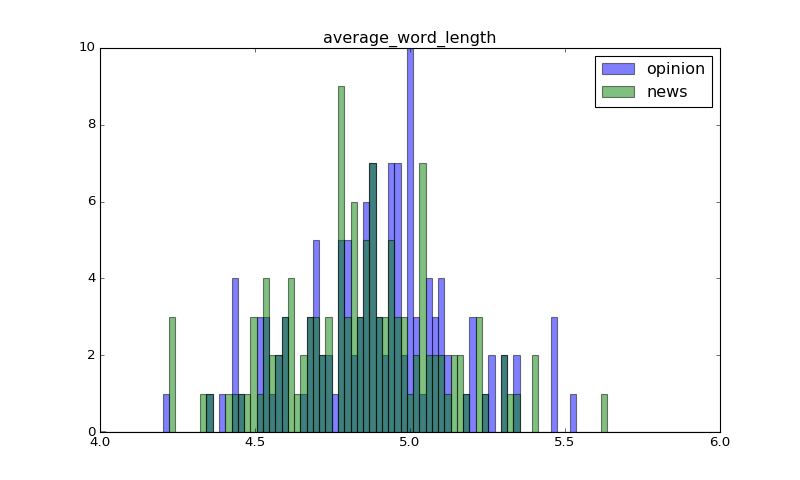

In [25]:
var = "average_word_length"
bins = np.linspace(4, 6, 100)
histogram(list(news_stats[var]), list(opinion_stats[var]), var, bins)

In [26]:
# Frequent words
def transform(articles):
    articles = [[w.lower() for w in article] for article in articles]
    articles = [[w for w in article if w.isalpha() and w not in STOP_WORDS] for article in articles]
    return articles
    
def frequent_words(articles, k=20):
    articles = transform(articles)
    all_words = functools.reduce(lambda a, b: a + b, articles)
    fd = nltk.FreqDist(all_words)
    unique_words = [w.lower() for w in functools.reduce(lambda a, b: list(a)+list(b), [set(article) for article in articles])]
    fd_doc = nltk.FreqDist(unique_words)
    return fd.most_common(k), fd_doc.most_common(k)

In [27]:
frequent_words(news_corpus)

([('said', 819),
  ('zika', 265),
  ('people', 234),
  ('state', 225),
  ('one', 210),
  ('new', 195),
  ('trump', 192),
  ('virus', 183),
  ('police', 179),
  ('would', 176),
  ('rubio', 170),
  ('year', 169),
  ('also', 153),
  ('according', 146),
  ('two', 139),
  ('health', 125),
  ('first', 123),
  ('federal', 121),
  ('could', 121),
  ('time', 116)],
 [('said', 110),
  ('one', 79),
  ('also', 78),
  ('people', 76),
  ('year', 73),
  ('new', 72),
  ('would', 67),
  ('two', 62),
  ('first', 62),
  ('state', 61),
  ('time', 61),
  ('last', 55),
  ('may', 55),
  ('like', 54),
  ('could', 54),
  ('according', 53),
  ('many', 52),
  ('even', 52),
  ('day', 51),
  ('three', 50)])

In [28]:
frequent_words(opinion_corpus)

([('would', 269),
  ('one', 216),
  ('president', 204),
  ('trump', 194),
  ('new', 182),
  ('justice', 180),
  ('like', 179),
  ('court', 176),
  ('people', 159),
  ('sanders', 144),
  ('even', 140),
  ('obama', 137),
  ('law', 133),
  ('could', 133),
  ('year', 131),
  ('many', 128),
  ('clinton', 124),
  ('also', 121),
  ('time', 120),
  ('political', 117)],
 [('one', 97),
  ('would', 92),
  ('read', 83),
  ('like', 83),
  ('even', 77),
  ('people', 76),
  ('also', 74),
  ('time', 73),
  ('new', 72),
  ('opinion', 71),
  ('go', 69),
  ('president', 69),
  ('board', 68),
  ('justice', 68),
  ('year', 66),
  ('look', 65),
  ('last', 65),
  ('could', 65),
  ('make', 65),
  ('including', 65)])

In [36]:
frequent_words(opinion_corpus+news_corpus)

([('said', 896),
  ('would', 445),
  ('one', 426),
  ('people', 393),
  ('trump', 386),
  ('new', 377),
  ('state', 328),
  ('year', 300),
  ('president', 298),
  ('court', 275),
  ('also', 274),
  ('like', 268),
  ('zika', 265),
  ('justice', 256),
  ('could', 254),
  ('law', 238),
  ('time', 236),
  ('many', 234),
  ('even', 230),
  ('last', 227)],
 [('one', 176),
  ('would', 159),
  ('said', 156),
  ('people', 152),
  ('also', 152),
  ('new', 144),
  ('year', 139),
  ('like', 137),
  ('time', 134),
  ('even', 129),
  ('last', 120),
  ('first', 120),
  ('could', 119),
  ('president', 118),
  ('many', 116),
  ('state', 114),
  ('years', 111),
  ('go', 108),
  ('two', 108),
  ('including', 104)])

In [29]:
def wordcloud(articles):
    wc = WordCloud(background_color="white", max_font_size=40, max_words=2000, stopwords=STOPWORDS)
    wc.generate(" ".join([w.lower() for w in functools.reduce(lambda a, b: a + b, articles)]))
    plt.figure()
    plt.imshow(wc)
    plt.axis("off")
    plt.show()

<IPython.core.display.Javascript object>


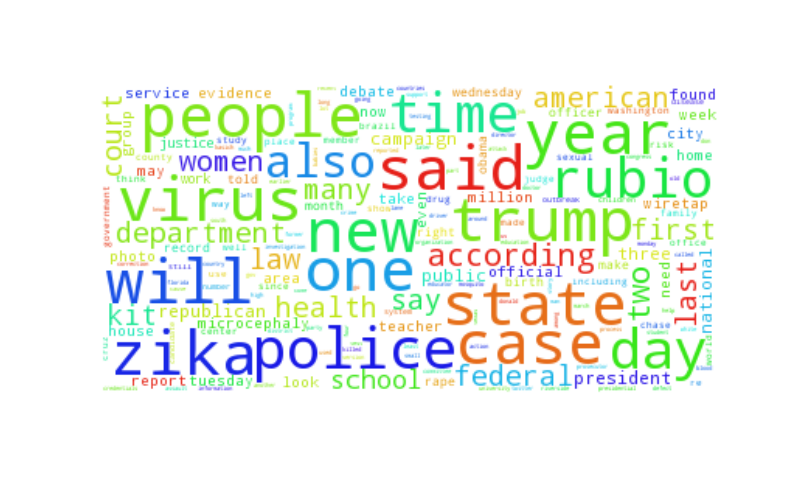

In [32]:
wordcloud(news_corpus)

<IPython.core.display.Javascript object>


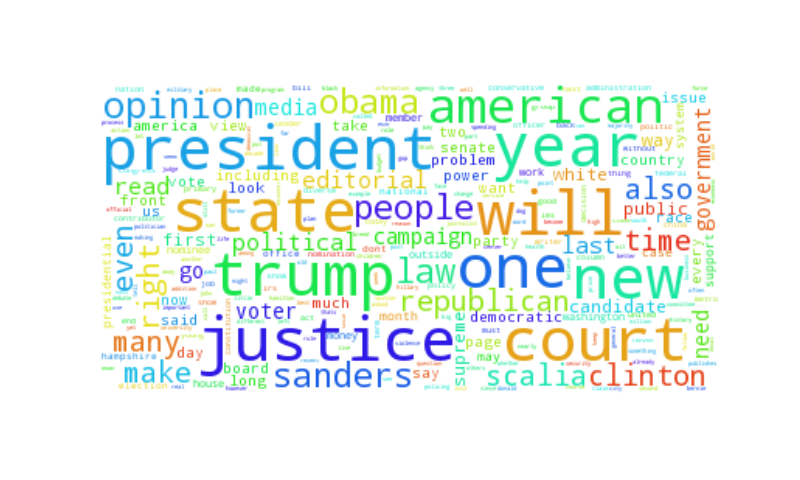

In [33]:
wordcloud(opinion_corpus)

<IPython.core.display.Javascript object>


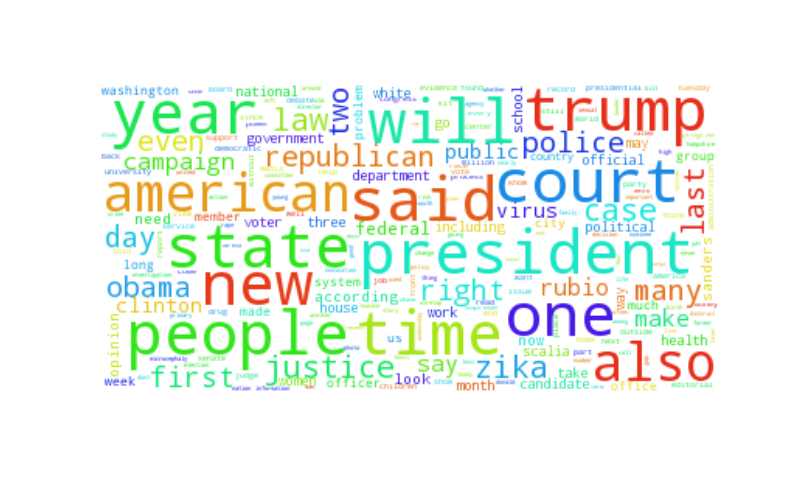

In [37]:
wordcloud(opinion_corpus+news_corpus)

In [42]:
# Part-of-speech tags
def frequent_tags(articles, title, stopwords=True):
    articles = [[w.lower() for w in article] for article in articles]
    articles = [[w for w in article if w.isalpha()] for article in articles]
    all_words = functools.reduce(lambda a, b: a + b, articles)
    if not stopwords:
        all_words = [w for w in all_words if w not in STOP_WORDS]
    tags = [tag for word, tag in nltk.pos_tag(all_words)]
    fd = nltk.FreqDist(tags)
    plt.title("Frequent POS tags")
    fd.plot(label=title)
    plt.legend(loc="best")

<IPython.core.display.Javascript object>


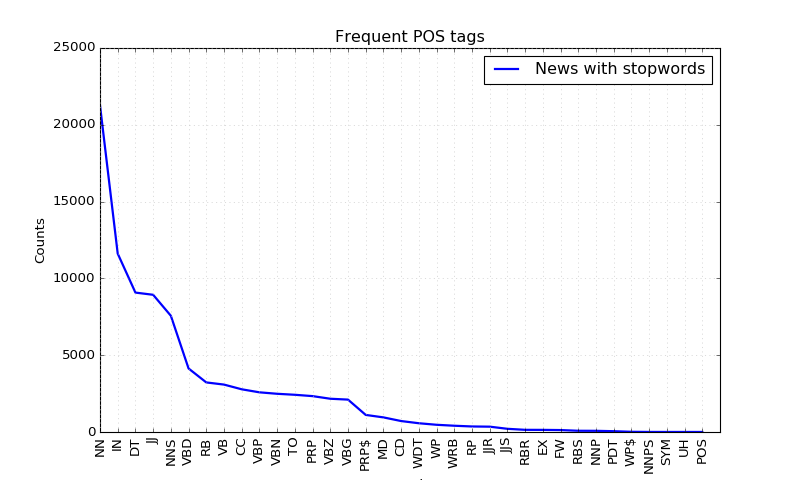

In [47]:
frequent_tags(news_corpus, "News with stopwords")

<IPython.core.display.Javascript object>


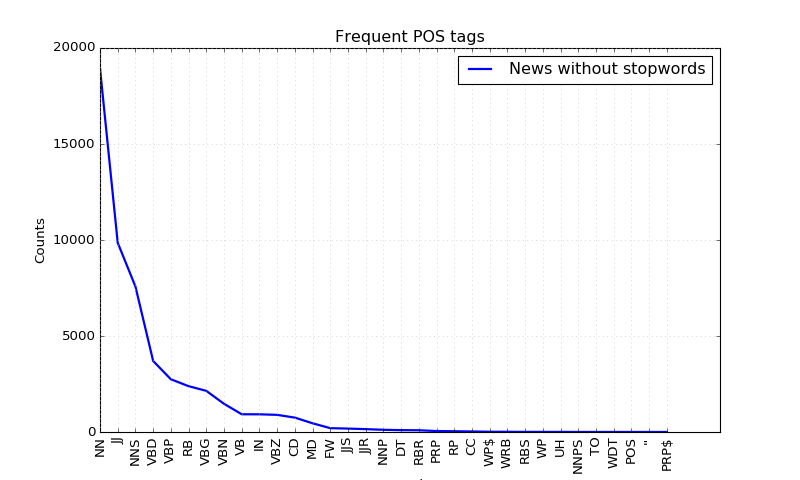

In [48]:
frequent_tags(news_corpus, "News without stopwords", stopwords=False)

<IPython.core.display.Javascript object>


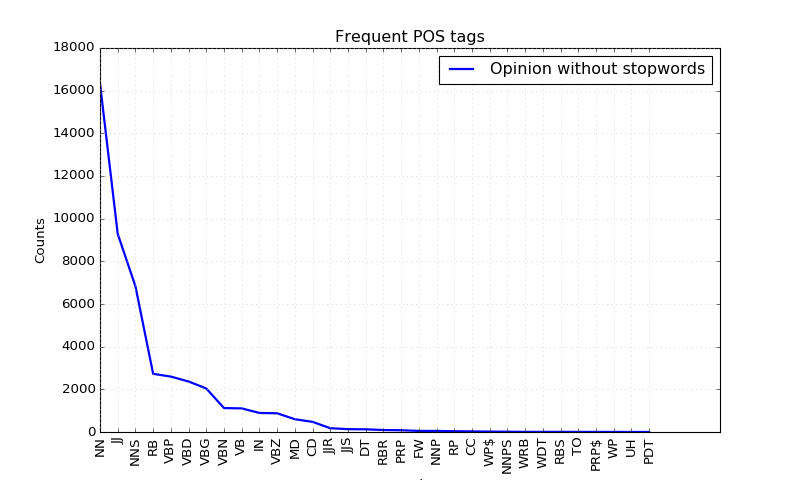

In [50]:
frequent_tags(opinion_corpus, "Opinion without stopwords", stopwords=False)

In [51]:
# shared words
def shared_words(corpora):
    rv = set([])
    for corpus in corpora:
        words = set(functools.reduce(lambda a, b: a+b, corpus))
        if len(rv) == 0:
            rv = words
        else:
            rv = rv.intersection(words)
    return rv

In [52]:
opinion_corpus = transform(opinion_corpus)
news_corpus = transform(news_corpus)
shared = shared_words((opinion_corpus, news_corpus))

<IPython.core.display.Javascript object>


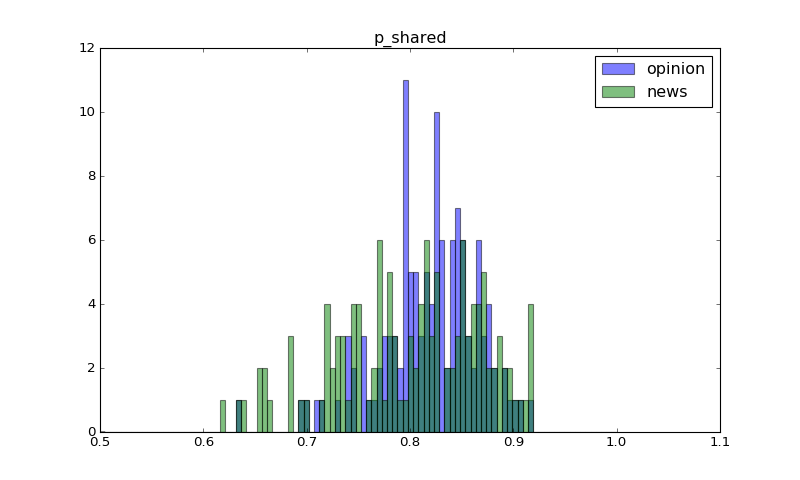

In [53]:
var = "p_shared"
bins = np.linspace(0.5, 1, 100)
histogram([len([w for w in article if w in shared])/len(article) for article in news_corpus], [len([w for w in article if w in shared])/len(article) for article in opinion_corpus], var, bins)

<IPython.core.display.Javascript object>


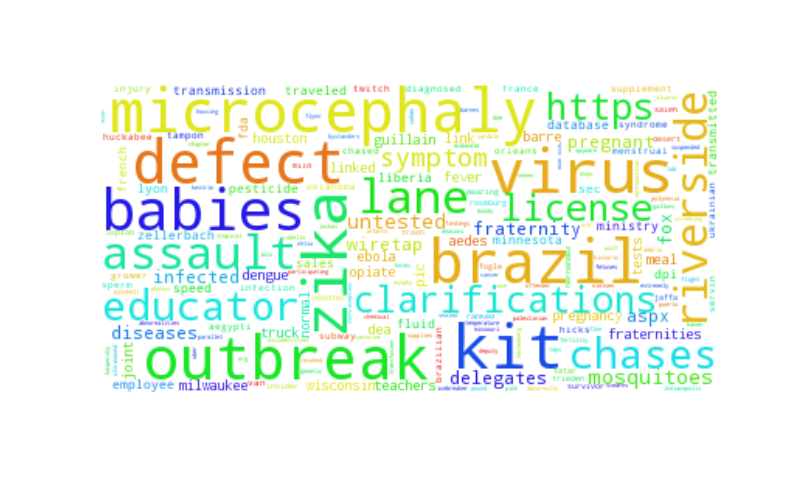

In [54]:
news_unique = [[w for w in article if w not in shared] for article in news_corpus]
wordcloud(news_unique)

<IPython.core.display.Javascript object>


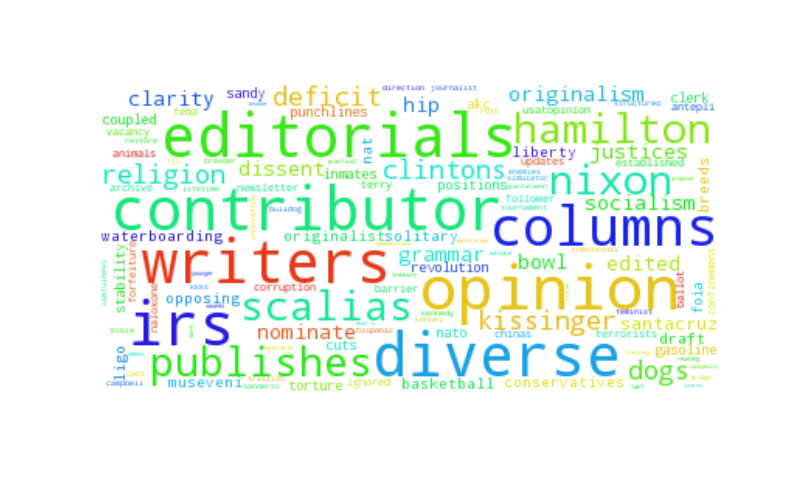

In [56]:
opinion_unique = [[w for w in article if w not in shared] for article in opinion_corpus]
wordcloud(opinion_unique)

In [238]:
# Negations
def mark_negations(articles):
    articles = [mark_negation(article) for article in articles]
    return [len([w for w in article if w[-3:] == 'NEG'])/len(article) for article in articles]

<IPython.core.display.Javascript object>


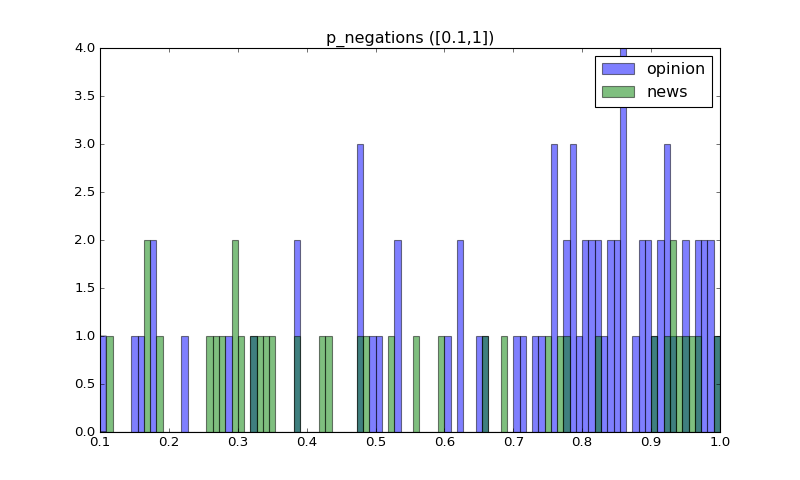

In [237]:
var = "p_negations"
bins = np.linspace(0, 1, 100)
histogram(mark_negations(news_corpus), mark_negations(opinion_corpus), var, bins)

In [246]:
# sent_tokenizer = nltk.tokenize.punkt.PunktSentenceTokenizer()
# sent_tokenizer.sentences_from_text("I am fine. How are you?")

['I am fine.', 'How are you?']

In [59]:
# seedwords
def build_opinion_seedwords():
    seedset = []
    seedroots = ['good', 'aseome','beautiful','decent','nice', 'excellent','good','bad','expensive','faulty','horrible',
               'poor','stupid','cheap','decent','effective','fantastic','happy','impress','jittery','light', 'madly',
                'nice', 'outstanding', 'perfect', 'quick', 'responsive', 'sharp', 'terrible','ultimate', 'wonderful']
    for word in seedroots:
        seedset += [s.name().split('.')[0] for s in wn.synsets(word)]
    return set(seedset)

SEEDWORDS = build_opinion_seedwords()

<IPython.core.display.Javascript object>


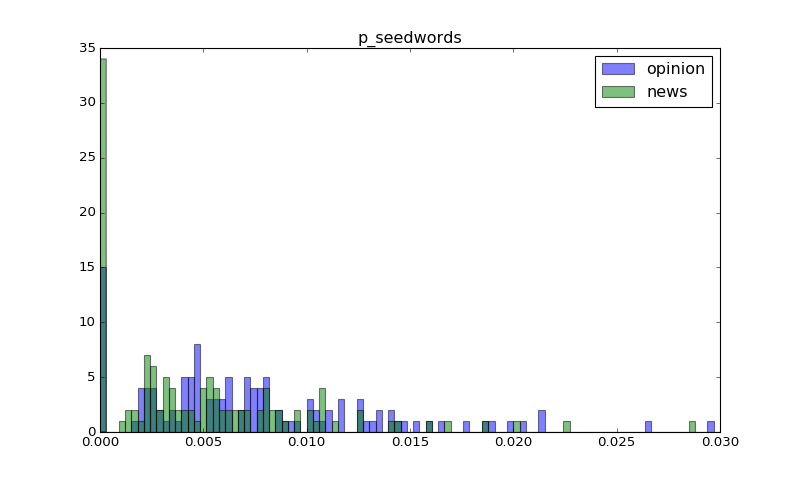

In [64]:
var = "p_seedwords"
bins = np.linspace(0, 0.03, 100)
histogram([len([w for w in article if w in SEEDWORDS])/len(article) for article in news_corpus], [len([w for w in article if w in SEEDWORDS])/len(article) for article in opinion_corpus], var, bins)